In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load Union City Area Price
df = pd.read_csv('../pre_data/UnionCity_price.csv')

In [3]:
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index)

In [4]:
data.head()

,price
date,
2010-11-01,1864.0
2010-12-01,1841.0
2011-01-01,1830.0
2011-02-01,1827.0
2011-03-01,1828.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2010-11-01 to 2019-01-01
Data columns (total 1 columns):
price    99 non-null float64
dtypes: float64(1)
memory usage: 1.5 KB


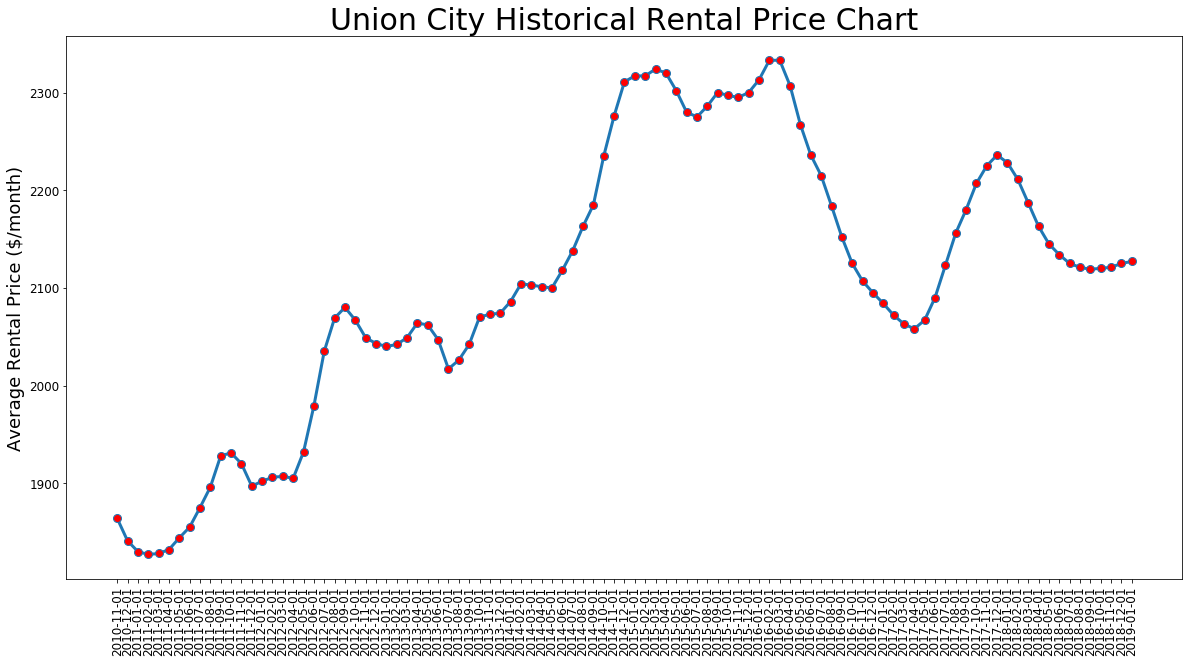

In [6]:
# Check the history data
m = df['date']
n = df['price']
plt.figure(figsize = (20, 10))
plt.plot(m, n, linewidth = 3, marker = 'o', markerfacecolor='red', markersize=8)
plt.title('Union City Historical Rental Price Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 90)
# for i, j in zip(m, n):
#     plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
plt.show()

## LSTM model - Long Short-Term Memory model

In [7]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# transform to supervised learning
supervised = timeseries_to_supervised(data, 1)
print(supervised.head())

             price   price
date                      
2010-11-01     0.0  1864.0
2010-12-01  1864.0  1841.0
2011-01-01  1841.0  1830.0
2011-02-01  1830.0  1827.0
2011-03-01  1827.0  1828.0


In [8]:
# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [9]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [10]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [11]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [12]:
# fit an LSTM network to training data
from keras.layers import LSTM

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.reset_states()
    return model

Using TensorFlow backend.


In [13]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [14]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-20], supervised_values[-20:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
predict = lstm_model.predict(train_reshaped, batch_size=1)

Instructions for updating:
Colocations handled automatically by placer.


Month=1, Predicted=2071.725611, Expected=2090.000000
Month=2, Predicted=2096.628838, Expected=2123.000000
Month=3, Predicted=2132.030604, Expected=2156.000000
Month=4, Predicted=2166.972783, Expected=2180.000000
Month=5, Predicted=2191.689686, Expected=2207.000000
Month=6, Predicted=2219.584964, Expected=2225.000000
Month=7, Predicted=2237.418204, Expected=2236.000000
Month=8, Predicted=2247.643067, Expected=2228.000000
Month=9, Predicted=2237.128695, Expected=2211.000000
Month=10, Predicted=2217.497840, Expected=2187.000000
Month=11, Predicted=2191.032821, Expected=2163.000000
Month=12, Predicted=2165.317250, Expected=2145.000000
Month=13, Predicted=2146.537661, Expected=2134.000000
Month=14, Predicted=2135.459904, Expected=2125.000000
Month=15, Predicted=2126.516639, Expected=2121.000000
Month=16, Predicted=2122.908363, Expected=2119.000000
Month=17, Predicted=2121.347299, Expected=2120.000000
Month=18, Predicted=2122.908643, Expected=2121.000000
Month=19, Predicted=2124.334653, Expe

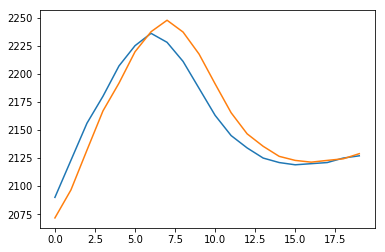

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-20:])
plt.plot(predictions)
plt.show()

1) Test RMSE: 18.410
2) Test RMSE: 21.820
3) Test RMSE: 18.683
4) Test RMSE: 15.592
5) Test RMSE: 25.999
6) Test RMSE: 20.390
7) Test RMSE: 18.782
8) Test RMSE: 18.020
9) Test RMSE: 21.198
10) Test RMSE: 23.218
11) Test RMSE: 20.240
12) Test RMSE: 17.517
13) Test RMSE: 15.894
14) Test RMSE: 19.722
15) Test RMSE: 18.017
16) Test RMSE: 24.569
17) Test RMSE: 17.473
18) Test RMSE: 18.089
19) Test RMSE: 17.484
20) Test RMSE: 17.196
21) Test RMSE: 18.309
22) Test RMSE: 19.041
23) Test RMSE: 15.697
24) Test RMSE: 17.717
25) Test RMSE: 20.012
26) Test RMSE: 18.766
27) Test RMSE: 21.445
28) Test RMSE: 17.211
29) Test RMSE: 14.022
30) Test RMSE: 17.193
            rmse
count  30.000000
mean   18.924148
std     2.628337
min    14.021528
25%    17.475724
50%    18.359642
75%    20.182820
max    25.998691


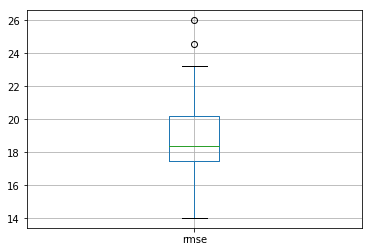

In [16]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()

In [17]:
# Build model

# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# transform the scale of the data
# fit scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(supervised_values)
# transform data
data_scaled = scaler.transform(supervised_values)

# fit the model
out_lstm_model = fit_lstm(data_scaled, 1, 3000, 4)

In [18]:
def prediction(step):
    result = list()
    for i in range(step):
        # make one-step forecast
        X, y = data_scaled[i, 0:-1], data_scaled[i, -1]
        yhat = forecast_lstm(out_lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, step+1-i)
        # store forecast
        result.append(yhat[0])
    return np.array(result)

In [19]:
# Get forecast 27 steps ahead in future
pred_long = prediction(step=27)
time_long = pd.date_range('20190201', periods=27, freq='MS')
pred_long_df = pd.DataFrame(np.round(pred_long,1), index = time_long, columns=['price'])
result_long = pd.concat([data, pred_long_df], axis=0)
result_long = result_long.reset_index()

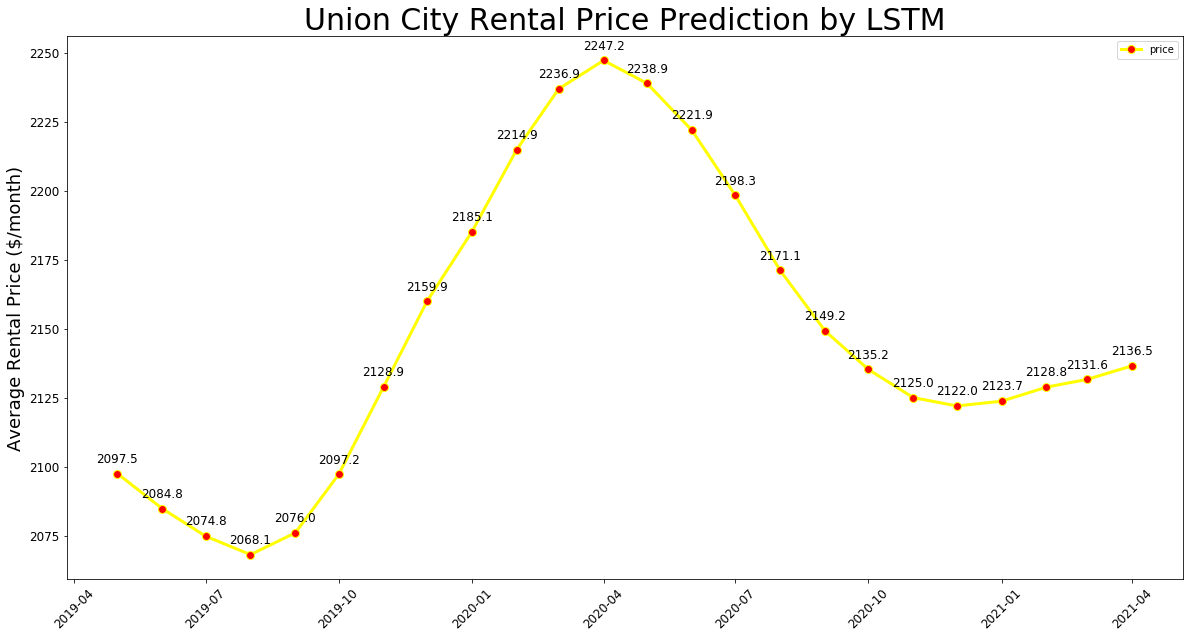

In [20]:
x2 = result_long['index'].tail(24)
y2 = result_long['price'].tail(24)

fig2 = plt.figure(figsize = (20, 10))
plt.plot(x2, y2, linewidth = 3, color='yellow', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Union City Rental Price Prediction by LSTM', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x2, y2):
    plt.text(i, j + 3, j, ha = 'center', va = 'bottom', fontsize = 12)
    
plt.legend()
plt.show()

In [21]:
fig2.savefig("../area_predict_pics/UnionCity_long.jpg")

In [22]:
result_long.to_csv('UnionCity_result_long.csv', index=False)

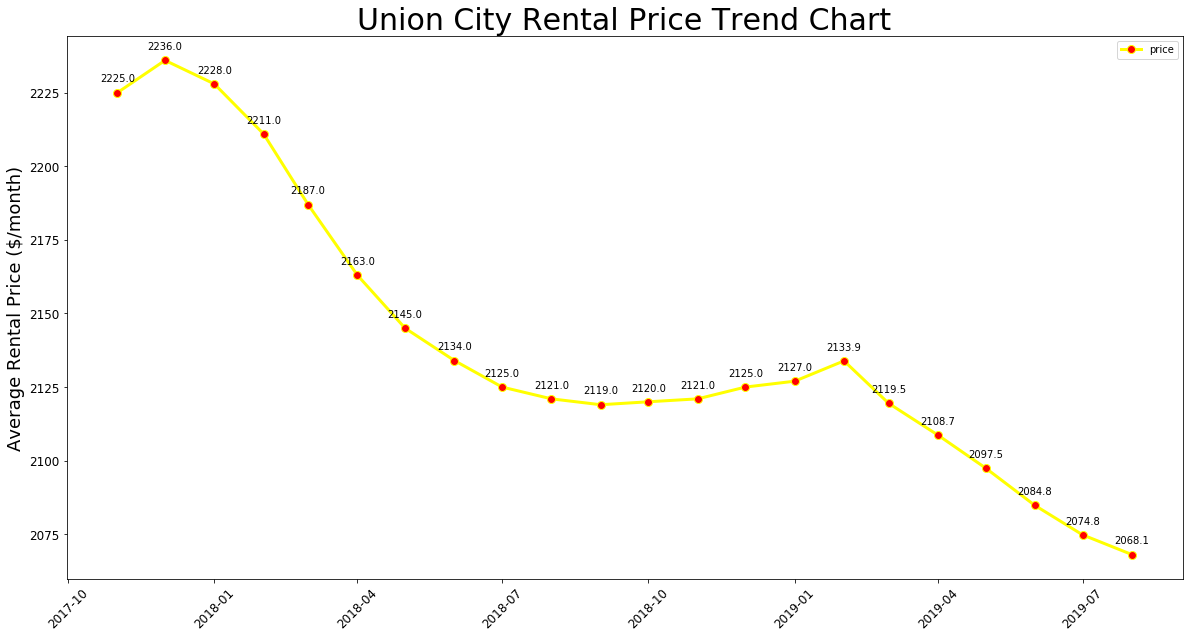

In [23]:
x = result_long['index'][-42: -20]
y = result_long['price'][-42: -20]

fig1 = plt.figure(figsize = (20, 10))
plt.plot(x, y, linewidth = 3, color='yellow', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Union City Rental Price Trend Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x, y):
    plt.text(i, j + 3, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.show()

In [24]:
fig1.savefig("../area_predict_pics/UnionCity.jpg")

## ARIMA model - AutoRegressive Integrated Moving Average model

In [25]:
# Select the best diff (Integrated)
from statsmodels.tsa.stattools import adfuller as ADF

print(ADF(data['price']))

(-2.0120639258516717, 0.2813086678556114, 5, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 635.4008789783361)


In [26]:
diff_1 = data.diff(1)
diff_1 = diff_1.dropna()
diff_1.columns = ['price_integrated']
print(ADF(diff_1['price_integrated']))

(-4.567937044602349, 0.00014793579673661353, 4, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 633.0191957422599)


In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox

noiseRes = acorr_ljungbox(diff_1, lags=1)
print(noiseRes)

(array([60.60740747]), array([6.96713439e-15]))


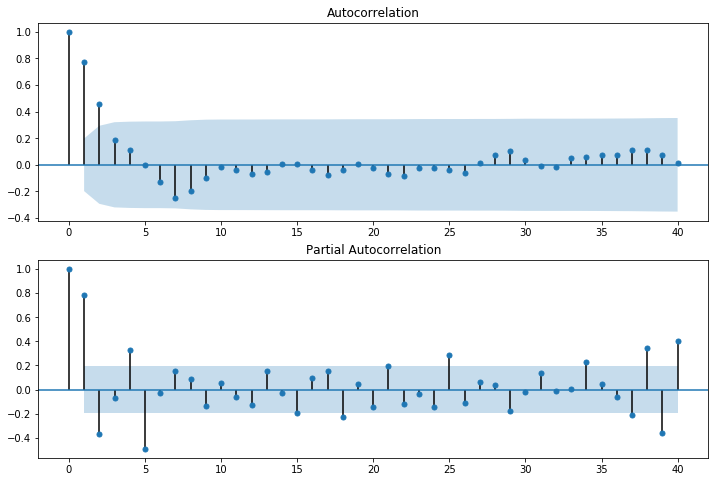

In [28]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_1,lags=40,ax=ax2)

In [29]:
# Select the best AR(p) and MA(q)
arma_mod20 = sm.tsa.ARMA(diff_1,(10,0),freq='MS').fit()
print(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)
arma_mod30 = sm.tsa.ARMA(diff_1,(0,1),freq='MS').fit()
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)
arma_mod40 = sm.tsa.ARMA(diff_1,(10,1),freq='MS').fit()
print(arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic)
arma_mod50 = sm.tsa.ARMA(diff_1,(9,0),freq='MS').fit()
print(arma_mod50.aic,arma_mod50.bic,arma_mod50.hqic)
arma_mod60 = sm.tsa.ARMA(diff_1,(9,1),freq='MS').fit()
print(arma_mod60.aic,arma_mod60.bic,arma_mod60.hqic)

736.327906582482 767.3475163265289 748.8746988872762
804.0746894269771 811.8295918629888 807.2113875031756
737.1923450227224 770.7969222454399 750.784703352916
734.6595333778071 763.0941756431833 746.1607596572017
736.4765310579319 767.4961408019788 749.023323362726


In [30]:
p,q = 9,0

In [31]:
from statsmodels.tsa.arima_model import ARIMA

# Build ARIMA(9,1,0) model
model = ARIMA(data, (p,1,q), freq='MS')
arima_result = model.fit()

In [32]:
# Get forecast 27 steps ahead in future
pred = arima_result.forecast(steps=27)
time = pd.date_range('20190201', periods=27, freq='MS')
pred_df = pd.DataFrame(np.round(pred[0],1), index = time, columns=['price'])
output = pd.concat([data, pred_df], axis=0)
output = output.reset_index()

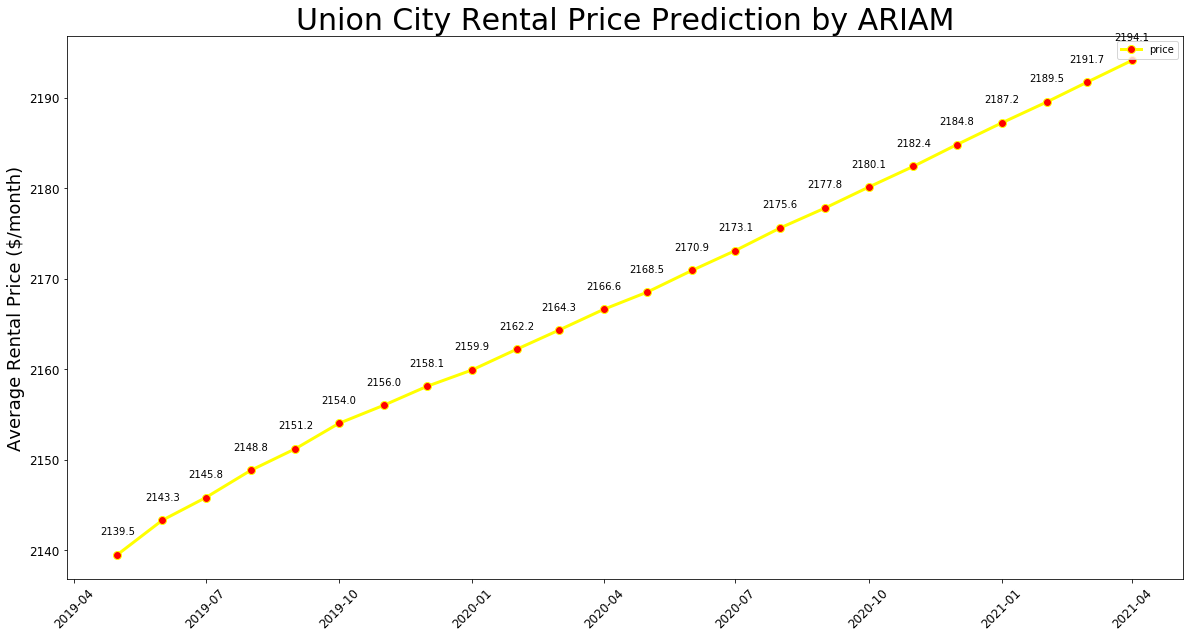

In [33]:
x3 = output['index'].tail(24)
y3 = output['price'].tail(24)

plt.figure(figsize = (20, 10))
plt.plot(x3, y3, linewidth = 3, color='yellow', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Union City Rental Price Prediction by ARIAM', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x3, y3):
    plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.show()

In [34]:
arima_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 763.0942  
Dependent Variable: D.price          Log-Likelihood:      -356.33   
Date:               2019-04-02 16:00 Scale:               1.0000    
No. Observations:   98               Method:              css-mle   
Df Model:           10               Sample:              12-01-2010
Df Residuals:       88                                    01-01-2019
Converged:          1.0000           S.D. of innovations: 9.029     
No. Iterations:     26.0000          HQIC:                746.161   
AIC:                734.6595                                        
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const             2.3004    3.1048   0.7409  0.4607  -3.7849   8.3857
ar.L1.D.price     1.2164    0.0999  12.1807  0.0000   1.0206   1.4121
ar.L2.D.price    -0.2741    0.1561  -1.7559  0.0826  -0.5801   0.0319
ar.L3.D.price    -0.6652    0.1594  -4.1718  0.0001  -0.9777  -0.3527
ar.L4.D.price     0.8184    0.1698   4.8191  0.0000   0.4856   1.1513
ar.L5.D.price    -0.2348    0.1879  -1.2497  0.2147  -0.6031   0.1335
ar.L6.D.price    -0.3042    0.1697  -1.7931  0.0764  -0.6367   0.0283
ar.L7.D.price     0.0927    0.1579   0.5871  0.5586  -0.2168   0.4023
ar.L8.D.price     0.1800    0.1554   1.1586  0.2498  -0.1245   0.4845
ar.L9.D.price    -0.1247    0.0988  -1.2616  0.2104  -0.3183   0.0690
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.1296            -0.0000           1.1296            -0.5000
AR.2           -1.1898            -0.8904           1.4861            -0.3978
AR.3           -1.1898             0.8904           1.4861             0.3978
AR.4            0.2691            -1.0635           1.0971            -0.2106
AR.5            0.2691             1.0635           1.0971             0.2106
AR.6            1.1385            -0.3861           1.2022            -0.0520
AR.7            1.1385             0.3861           1.2022             0.0520
AR.8            1.0689            -0.8401           1.3596            -0.1060
AR.9            1.0689             0.8401           1.3596             0.1060
====================================================================

"""